<h1 style="color: blue; text-align: center; font-size: 30px;"><b>Time Series Forecasting with ARIMA and Prophet  </b></h1>

### Time Series Analysis  
Time series analysis involves analyzing data points collected or recorded at specific time intervals. The goal is to identify patterns, trends, and seasonality in the data, which can be used to make predictions about future values. Key components of time series include:  
- **Trend**: The long-term increase or decrease in the data.  
- **Seasonality**: Patterns that repeat at regular intervals (e.g., daily, monthly, yearly).  
- **Noise**: Random variations or irregular fluctuations in the data.  
Time series analysis is widely used in various domains such as finance, sales, weather forecasting, and inventory management.  

### Time Series Forecasting  
Time series forecasting involves predicting future values of a variable based on its historical data. Two popular methods for this are **ARIMA** (Auto-Regressive Integrated Moving Average) and **Prophet**.  

#### ARIMA (Auto-Regressive Integrated Moving Average)  
ARIMA is a statistical model that works by understanding the patterns in a time series. It has three main components:  
1. **Auto-Regression (AR)**: Captures the relationship between the current value and its past values.  
2. **Integrated (I)**: Makes the time series stationary by differencing it to remove trends.  
3. **Moving Average (MA)**: Models the relationship between the current value and past forecast errors.  

ARIMA is best suited for univariate time series data and works well when the dataset exhibits clear autocorrelation or linear trends. However, it may require manual tuning of hyperparameters (p, d, q), which represent the AR, I, and MA terms, respectively.  

#### Prophet  
Prophet, developed by Facebook, is a forecasting tool designed to handle time series data with trends and seasonality. It is intuitive and user-friendly, with minimal need for parameter tuning. Key features of Prophet include:  
- **Additive and Multiplicative Seasonality**: Handles complex seasonality (e.g., daily, weekly, yearly patterns).  
- **Trend Analysis**: Models long-term trends and supports custom holiday effects.  
- **Robustness to Missing Data and Outliers**: Performs well even with incomplete datasets.  

Prophet is particularly useful for business and industry applications, where datasets often have multiple seasonalities or external factors impacting trends.  

### Comparison  
| **Feature**              | **ARIMA**                                         | **Prophet**                                    |
|--------------------------|--------------------------------------------------|-----------------------------------------------|
| **Best For**             | Small, structured datasets with linear patterns  | Non-stationary data with strong seasonality   |
| **Stationarity Requirement** | Requires stationary data                       | Can handle non-stationary data                |
| **Parameter Tuning**     | Manual tuning of (p, d, q) required              | Minimal parameter tuning                      |
| **Handling Missing Data**| Limited                                          | Robust to missing data                        |
| **Use Cases**            | Finance, stock price prediction                  | Business, sales, demand forecasting           |  

Both models are powerful, and the choice depends on the nature of the dataset and the forecasting requirements.  


### 1. Load and Visualize Time Series Data

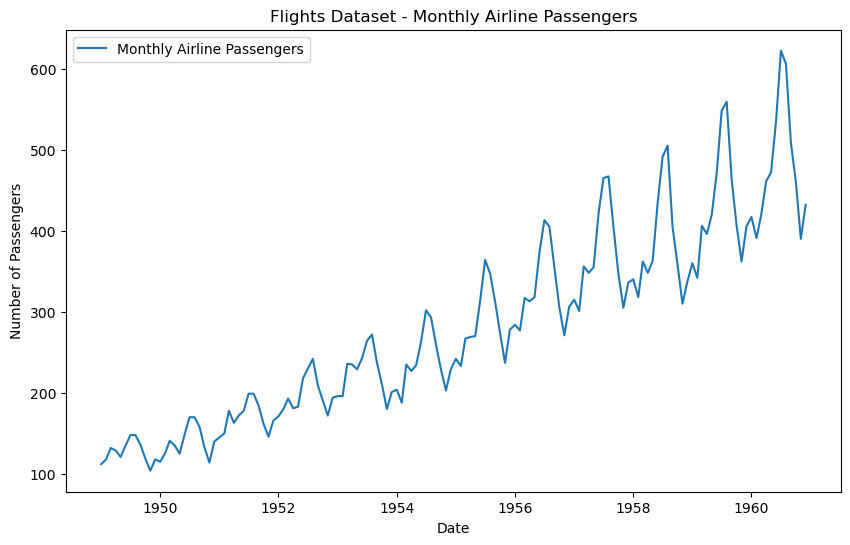

In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


# Load the flights dataset
flights = sns.load_dataset("flights")

# Convert the month names to numerical values
month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}
flights['month'] = flights['month'].map(month_mapping)

# Create the 'date' column by combining 'year' and 'month'
flights['date'] = pd.to_datetime(flights[['year', 'month']].assign(day=1))

# Set the 'date' column as the index
flights.set_index('date', inplace=True)

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(flights['passengers'], label='Monthly Airline Passengers')
plt.title('Flights Dataset - Monthly Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


### 2. Stationarity Check with ADF Test
Use the Augmented Dickey-Fuller Test from statsmodels to check if the time series is stationary.

In [19]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF Test
result = adfuller(flights['passengers'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")



ADF Statistic: 0.8153688792060433
p-value: 0.9918802434376409
The time series is not stationary.


In [21]:
#Apply Differencing:
# Apply first-order differencing
flights['passengers_diff'] = flights['passengers'].diff().dropna()

# Check if the differenced series is stationary
result = adfuller(flights['passengers_diff'].dropna())
print("ADF Statistic after differencing:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is still not stationary.")


ADF Statistic after differencing: -2.8292668241699865
p-value: 0.05421329028382727
The differenced time series is still not stationary.


In [23]:
# Apply second-order differencing
flights['passengers_diff_2'] = flights['passengers_diff'].diff().dropna()

# Check if the second differenced series is stationary
result = adfuller(flights['passengers_diff_2'].dropna())
print("ADF Statistic after second differencing:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The second differenced time series is stationary.")
else:
    print("The second differenced time series is still not stationary.")


ADF Statistic after second differencing: -16.384231542468495
p-value: 2.7328918500143186e-29
The second differenced time series is stationary.


### 3. Apply ARIMA for Forecasting
Use the statsmodels library to fit an ARIMA model and forecast future values.

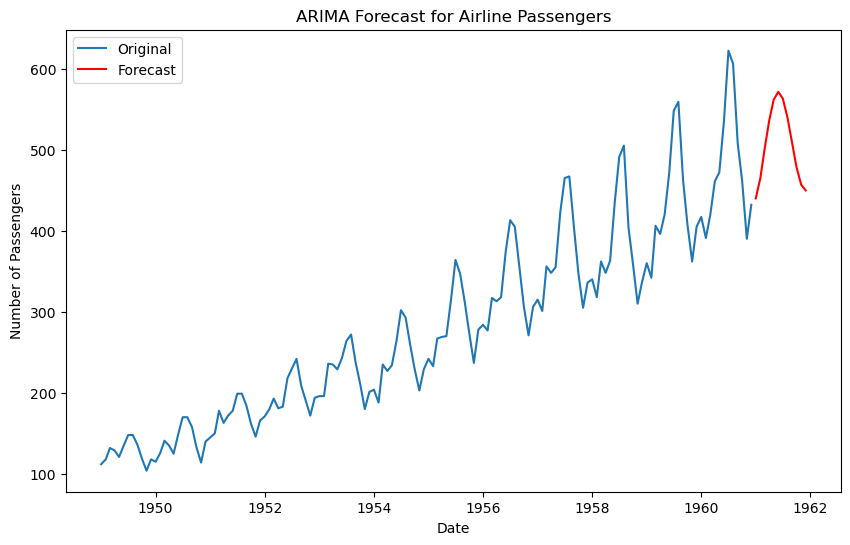

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.simplefilter("ignore")

# Fit ARIMA model
model = ARIMA(flights['passengers'], order=(2, 1, 2))  # Replace (2, 1, 2) with optimal values
arima_result = model.fit()

# Forecast next 12 months
forecast = arima_result.get_forecast(steps=12)
forecast_index = pd.date_range(start=flights.index[-1], periods=12, freq='M')
forecast_values = forecast.predicted_mean

# Plot forecast
plt.figure(figsize=(10, 6))
plt.plot(flights['passengers'], label='Original')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.title('ARIMA Forecast for Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


### 4. Apply Prophet for Forecasting
Use the fbprophet (or prophet) library for forecasting and visualize the results.

In [35]:
# pip install prophet

23:36:29 - cmdstanpy - INFO - Chain [1] start processing
23:36:29 - cmdstanpy - INFO - Chain [1] done processing


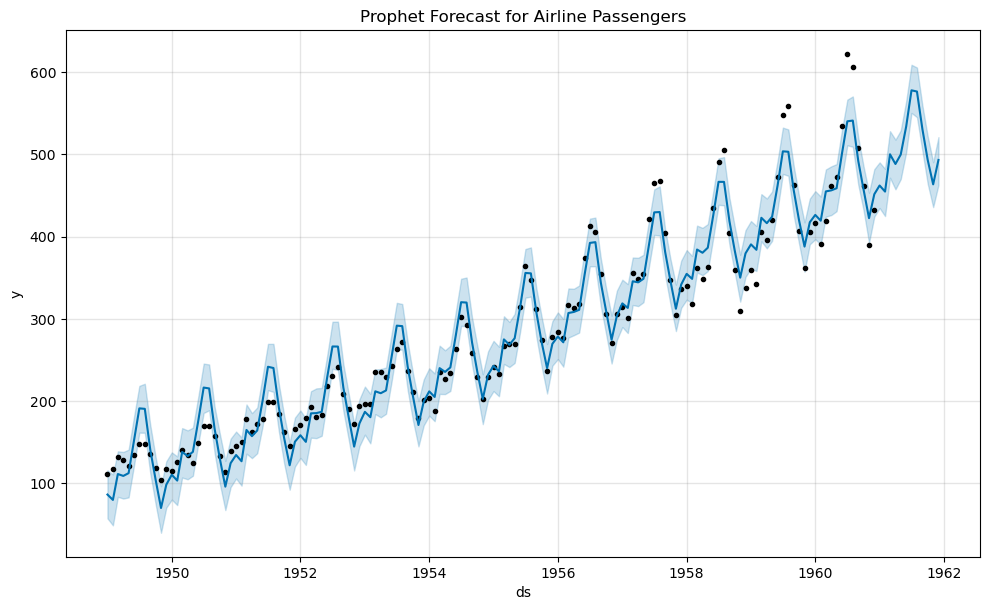

In [37]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = flights.reset_index().rename(columns={'date': 'ds', 'passengers': 'y'})

# Fit the model
model = Prophet()
model.fit(df_prophet)

# Make future predictions
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast for the next 12 months
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Prophet Forecast for Airline Passengers")
plt.show()


### 5. Evaluate Model Performance
Use metrics like Mean Absolute Error (MAE), Root Mean Square Error (RMSE), or Mean Absolute Percentage Error (MAPE) to evaluate model performance.

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Train-test split
train = flights['passengers'][:-12]
test = flights['passengers'][-12:]

# Fit ARIMA on training data
arima_model = ARIMA(train, order=(2, 1, 2)).fit()

# Generate predictions
arima_forecast = arima_model.forecast(steps=12)

# Calculate metrics
mae = mean_absolute_error(test, arima_forecast)
rmse = np.sqrt(mean_squared_error(test, arima_forecast))

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Square Error (RMSE):", rmse)


Mean Absolute Error (MAE): 41.83479811093208
Root Mean Square Error (RMSE): 55.22283889874781
